<h1><center>DSA 4212: Year 2019-2020</center></h1>
<h3><center> Assignment 2 (Deadline: 1st of May 2020 at 23:59) </center></h3>
<h3><center> To Be submitted on the lumiNUS </center></h3>
<h2><center> Group Number: ???? </center></h2>
<h2><center> Filename: assignment_2_XX.ipynb where XXX is your group number</center></h2>
<h2><center> Group Member 1: Student Name, Student ID </center></h2>
<h2><center> Group Member 2: Student Name, Student ID </center></h2>
<h2><center> Group Member 3: Student Name, Student ID </center></h2>



In [102]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy



# Exercise 1: Image inpainting

Load the image `img_bad.png` and restore it as well as you can.

**Remark**: if you use `L-BFGS` for image processing, it may be a good idea to set the tolerance to a low value i.e. to use the option `tol=10**-8` or something of that order

(-0.5, 511.5, 341.5, -0.5)

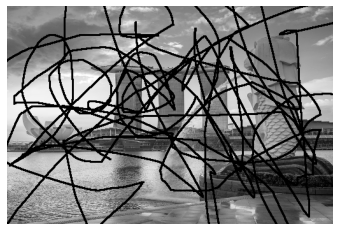

In [82]:
path_img = "/home/joycelim98/img_bad.png"
im = onp.array(imageio.imread(path_img).astype(float))/255.
# plt.figure(figsize=(10,10))
plt.imshow(im,cmap="gray")
plt.axis("off")

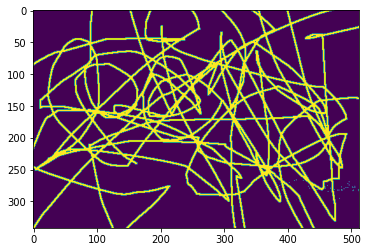

In [78]:
#maybe useful to know where all the black pixels are:
plt.imshow(im==0)

In [76]:
im.shape #342 rows and 512 columns

(342, 512)

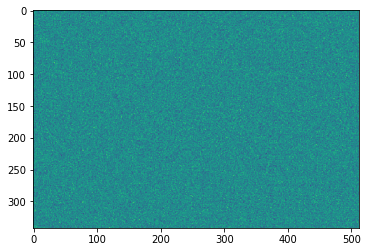

In [118]:
r = 100
U_init = onp.random.normal(0,1,size=(342,r)) / onp.sqrt(342*r)
V_init = onp.random.normal(0,1,size=(r,512)) / onp.sqrt(512*r)

plt.imshow(U_init @ V_init)

In [119]:
def loss(U,V):
    return np.mean(np.absolute(im - U @ V) )

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

In [120]:
U = onp.copy(U_init)
V = onp.copy(V_init)

In [121]:
learning_rate = 10.
n_iter = 500
loss_history = []

for k in range(n_iter):
    gradient_u = grad_loss_u(U,V)
    gradient_v = grad_loss_v(U,V)
    
    U = U - learning_rate * gradient_u
    V = V - learning_rate * gradient_v
    
    current_loss = loss(U,V)
    loss_history.append(current_loss)

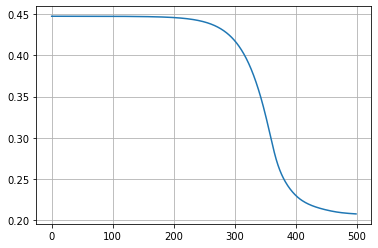

In [122]:
plt.plot( loss_history )
plt.grid(True)

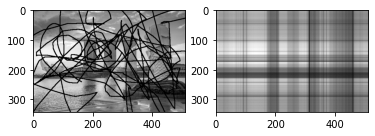

In [123]:
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(U @ V, cmap="gray")

# LBFGS


In [129]:
#let us define a function that does a few steps of LBFGS with U fixed
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(r,512)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(r,512)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    
    V_final = traj["x"].reshape(r,512)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(342,r)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(342,r)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(342,r)
    return U_final




In [130]:
U,V = onp.copy(U_init), onp.copy(V_init)

In [132]:
LBFGS_iter = 1000
n_iter = 10000
loss_history = []

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



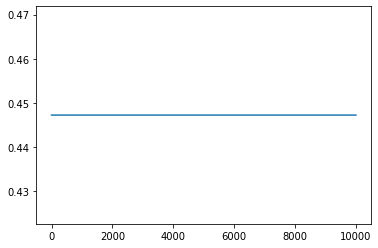

In [133]:
plt.plot(loss_history)

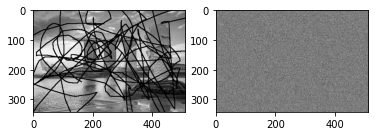

In [134]:
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(U @ V, cmap="gray")

# Exercise 2: image deblurring

Load the image `film.png` and restore it as well as you can.  

**Remark**: if you use `L-BFGS` for image processing, it may be a good idea to set the tolerance to a low value i.e. to use the option `tol=10**-8` or something of that order

(-0.5, 299.5, 241.5, -0.5)

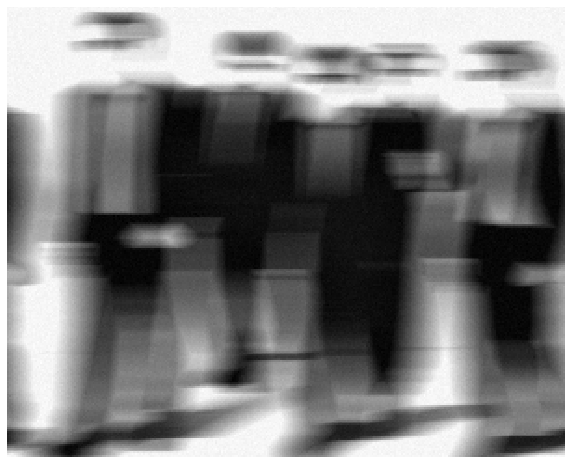

In [4]:
#load image
path_img = "/Users/alex/Google Drive/teaching/2019_DSA4212/film.png"
im_blurred = onp.array(imageio.imread(path_img).astype(float))
#display
plt.figure(figsize=(10,10))
plt.imshow(im_blurred, cmap="gray")
plt.axis("off")

To do so, you can assume that this noisy image has been obtained by using the following process.

In [245]:
def blurr(im):
    S = np.zeros_like(im)
    for k in range(30):
        S += np.roll(im, shift=(k+1), axis=1)
    return S/30.

#for some unkown clean image "im_clean"
im_blurred = blurr(im_clean) + onp.random.normal(0,0.01,size=im_clean.shape)

#your job is to find back a good estimate of this unknown clean image.
#prof alr told us how he blurred the image

#new function:
plt.imshow(np.roll(im,shift=200, axis=1)) #this means to shift the image by 200 pixels to the right, like rearranging the pixels on the imge

# Exercise 3: SIR estimation

Consider a population with a fraction $S \in (0,1)$ of people susceptible of contracting a disease, a fraction $I \in (0,1)$ of infected people, and a fraction $R \in (0,1)$ of recovered people. 
If at day $t$ the values of these fractions are $(S_t, I_t, R_t)$, the values at day $t+1$ are 

$$S_{t+1} = \frac{\widehat{S}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
\qquad \textrm{and} \qquad
I_{t+1} = \frac{\widehat{I}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
\qquad \textrm{and} \qquad
R_{t+1} = \frac{\widehat{R}_{t+1}}{\widehat{S}_{t+1}+\widehat{I}_{t+1}+\widehat{R}_{t+1}}
$$

where

$$
\widehat{S}_{t+1} = S_t \, \exp[-\beta \, I_t]
\qquad \textrm{and} \qquad
\widehat{I}_{t+1} = I_t \, \exp[\beta \, S_t - \gamma]
\qquad \textrm{and} \qquad
\widehat{R}_{t+1} = R_t + \gamma \, I_t.
$$

for some unkown parameter $\beta > 0$ and $\gamma > 0$ to be estimated.
Assume that $S_0 = 0.99$ and $I_0=0.01$ and $R_0=0$. One collects data $[y_1, y_2, \ldots, y_{30}]$ during 30 consecutive days where  

$$y_t \sim \mathbf{Poisson}(\textrm{mean}=1000 \times I_t)$$

**Question 1:** Find the laximum likelihood estimates of the parameter $\beta$ and $\gamma$.  
**Question 2:** Generate artificial observations from your fitted model and check whether the artificial observations are close to the collected observations.  
**Question 3:** Can you give a confidence interval for your estimate of $\beta$ and $\gamma$? [this can be done by computing the inverse of the Hessian at the MLE, etc... If you do not know how to do this, google it.] 

**Remark:** the parameter $\beta$ and $\gamma$ are positive. It may be useful to reparametrize the model in terms of $B = \log[\beta]$ and $G = \log[\gamma]$.  
**Remark:** Note that if you use `jax`, it is normal that it takes a bit of time to compute the gradients.   
**Remark:** Note that if you use `jax.jit`, it is normal that it takes a bit of time the first time that the gradient is computed. That is because it is difficult to optimize functions with `for` loops inside them.






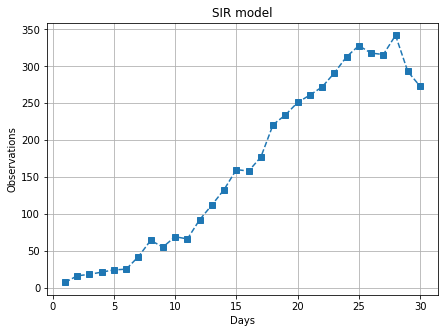

In [225]:
plt.figure(figsize=(7,5))
y_history = onp.array([7, 16, 18, 21, 24, 25, 42, 64, 55, 69, 66, 92, 112, 133, 160, 158, 177, 221, 234, 251, 261, 272, 291, 313, 328, 318, 316, 342, 293, 273])
plt.plot(np.arange(1,31), y_history, "--s")
plt.ylabel("Observations")
plt.xlabel("Days")
plt.title("SIR model")
plt.grid(True)

#S+i+r =1
#prof define a function to let us know how s i and r change as t changes from t to t+1
#impt part i that we do not know beta and gamma
#yt is our data, which we collec t everyday ,we collect data on how many ppl are infected so yt = num of ppl infected on day t
#goal is to esitmate beta and gamma, can do thro mle
#given data, how to estimate beta adn gamma
#then once we estimate beta and gamma, we should simullate and generate some fake observations, then it shoould look like the one belowto make sure its corret
#then also find the CI for our estimations

## Book recommendations

The files `books.csv` and `ratings.csv` contain the description of $1000$ books and the ratings of $53424$ users. Build a book recommendation system out of this dataset.

**remark**: it may be a good idea to shuffle and split the data into a train/test subset.  
**remark**: think first about an appropriat metric to quantify how well your model is doing.  
**remark**: it may be a good idea to come-up first with one or two baseline/naive models.  



In [228]:
import pandas as pd
ratings = pd.read_csv("/Users/alex/Dataset/books/ratings.csv")
books = pd.read_csv("/Users/alex/Dataset/books/books.csv", encoding = "ISO-8859-1")

In [241]:
nb_of_users = len(onp.unique(onp.array(ratings["user_id"])))
nb_of_books = len(books["book_id"])
print("Number of books:{} \t Number of Users:{}".format(nb_of_books, nb_of_users))

Number of books:10000 	 Number of Users:53424


In [ ]:
ratings# user number 1 read book 258 and gave that book a rating of 5... etc

#firt is to shuffle the dataset,then split into training and test set and train on training set and test on test set.
#need to state explicitly what is being optimised and how. mse , total variance?
